In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from lightgbm import LGBMClassifier

from pycaret.classification import setup, evaluate_model, compare_models, plot_model

import optuna

C:\Users\Anes3\Anaconda3\envs\pycaret_env\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data

In [2]:
train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')

In [3]:
train.shape

(414, 7)

In [4]:
train.head()

gravity    ph  osmo  cond  urea  calc  target
id                                               
0     1.013  6.19   443  14.8   124  1.45       0
1     1.025  5.40   703  23.6   394  4.18       0
2     1.009  6.13   371  24.5   159  9.04       0
3     1.021  4.91   442  20.8   398  6.63       1
4     1.021  5.53   874  17.8   385  2.21       1

In [5]:
train.target.value_counts()

0    230
1    184
Name: target, dtype: int64

In [6]:
X = train.drop('target', axis=1).copy()
y = train.target

In [7]:
X1 = pd.concat([X, test])

def create_new_features(data):
    # Ion product of calcium and urea
    data["ion_product"] = data["calc"] * data["urea"]

    # Calcium-to-urea ratio
    data["calcium_to_urea_ratio"] = data["calc"] / data["urea"]

    # Electrolyte balance
    data["electrolyte_balance"] = data["cond"] / (10 ** (-data["ph"]))

    # Osmolality-to-specific gravity ratio
    data["osmolality_to_sg_ratio"] = data["osmo"] / data["gravity"]
    
    ## Add Feature engineering part 
    # The product of osmolarity and density is created as a new property
    data['osmo_density'] = data['osmo'] * data['gravity']
    
    # Converting pH column to categorical variable
    data['pH_cat'] = pd.cut(data['ph'], bins=[0, 4.5, 6.5, 8.5, 14], labels=['sangat acidic', 'acidic', 'neutral', 'basic'])
    dummies = pd.get_dummies(data['pH_cat'])
    data = pd.concat([data, dummies], axis=1)
    
    # Deleting columns using dummy variables.
    data = data.drop(['pH_cat', 'sangat acidic' , 'basic','neutral','ph'], axis=1)
    
    return data

X2 = create_new_features(X1)

X = X2.iloc[:len(train), :]
test = X2.iloc[len(train):, :]

# Base Model

In [8]:
rf = RandomForestClassifier(random_state=0)

results = []

kf = KFold(n_splits=10, shuffle=True, random_state=0)

r = cross_val_score(rf, X, y, scoring='roc_auc')

results.append(r)

print(f'ROC score: {np.mean(results).round(2)}')

ROC score: 0.76


# Model Selection

In [9]:
_ = setup(data=train, target='target')

In [10]:
best = compare_models(sort='AUC')

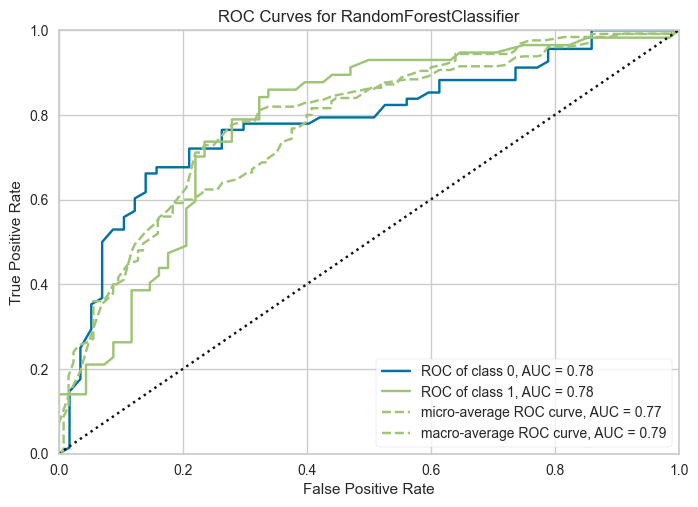

In [11]:
plot_model(best, plot='auc')

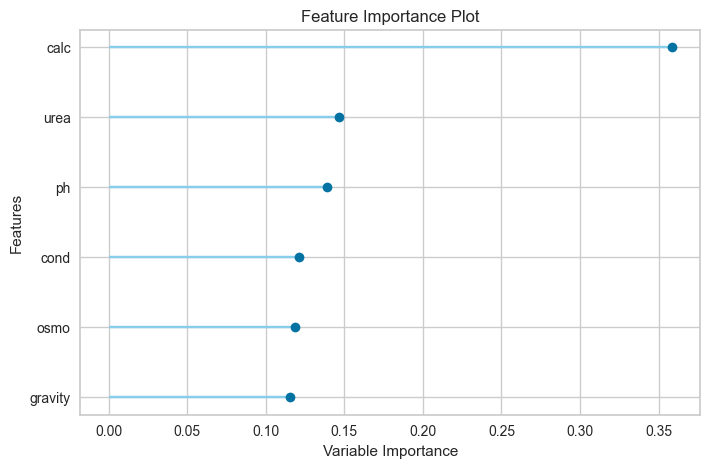

In [12]:
plot_model(best, plot='feature')

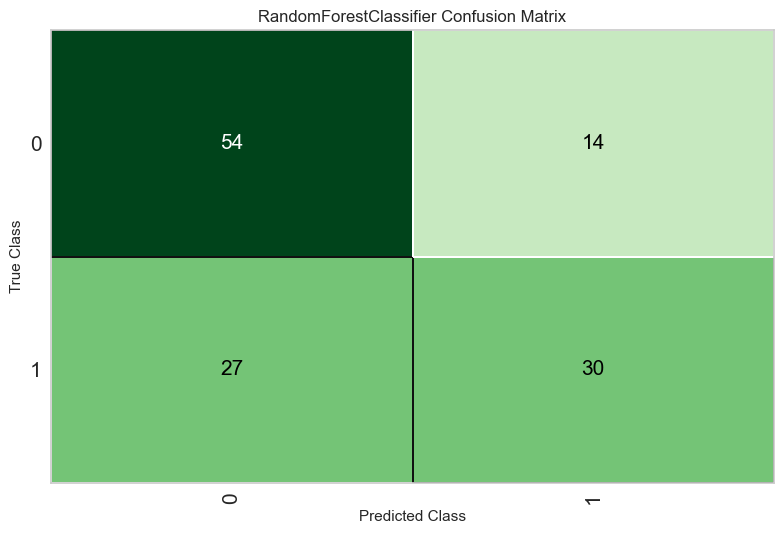

In [13]:
plot_model(best, plot='confusion_matrix')

# Hyperparameters Tuning

In [14]:
def gbc(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0)
    }
    
    model = GradientBoostingClassifier(**params)
    
    model.fit(X, y)
    
    cv_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
    
    return np.mean(cv_scores)

In [15]:
def rf(trial):
    max_depth = trial.suggest_int('max_depth', 1, 100)
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
          
    model = RandomForestClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split
    )
    
    model.fit(X, y)
    
    cv_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
    
    return np.mean(cv_scores)

In [16]:
def ada(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'base_estimator': DecisionTreeClassifier(max_depth=trial.suggest_int('max_depth', 1, 10))
    }
    
    abc = AdaBoostClassifier(**params)
    
    abc.fit(X, y)
    
    cv_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
    
    return np.mean(cv_scores)

In [17]:
# def lr(trial):
#     C = trial.suggest_loguniform('C', 0.001, 1000)
#     solver = trial.suggest_categorical('solver', ['newton-cg', 'liblinear', 'sag', 'saga'])
    
#     if solver=='sag' or solver=='newton-cg':
#         penalty = 'l2'
#         multi_class = trial.suggest_categorical('multi_class', ['ovr', 'multinomial'])
#     elif solver=='liblinear':
#         multi_class = 'ovr'
#         penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
#         if penalty==1:
#             l1_ratio = trial.suggest_float(0, 1)
#     elif solver=='saga':
#         multi_class = trial.suggest_categorical('multi_class', ['ovr', 'multinomial'])
#         penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
#         if penalty==1:
#             l1_ratio = trial.suggest_float(0, 1)
          
#     model = LogisticRegression(
#         C=C,
#         penalty = penalty,
#         solver=solver,
#         multi_class=multi_class
#     )
    
#     model.fit(X, y)
    
#     cv_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
    
#     return np.mean(cv_scores)

In [18]:
def lda(trial):
    solver = trial.suggest_categorical('solver', ['svd', 'lsqr', 'eigen'])
          
    model = LinearDiscriminantAnalysis(
        solver=solver
    )
    
    model.fit(X, y)
    
    cv_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
    
    return np.mean(cv_scores)

In [19]:
def et(trial):
    max_depth = trial.suggest_int('max_depth', 1, 100)
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None])

          
    model = ExtraTreesClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        max_features=max_features
    )
    
    model.fit(X, y)
    
    cv_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
    
    return np.mean(cv_scores)

In [20]:
# def nb(trial):
#     var_smoothing  = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-3)
          
#     model = GaussianNB(
#         var_smoothing=var_smoothing
#     )
    
#     model.fit(X, y)
    
#     cv_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
    
#     return np.mean(cv_scores)

In [21]:
def lightgbm(trial):
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'binary_logloss',
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 50),
        'num_leaves': trial.suggest_int('num_leaves', 2, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-9, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-9, 10.0),
        'random_state': 0
    }

    model = LGBMClassifier(**params)

    model.fit(X, y)
    
    cv_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
    
    return np.mean(cv_scores)

In [22]:
# study = optuna.create_study(direction='maximize')
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(gbc, n_trials=100)
# study.best_params

In [23]:
# study = optuna.create_study(direction='maximize')
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(rf, n_trials=100)
# study.best_params

In [24]:
# study = optuna.create_study(direction='maximize')
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(lr, n_trials=100)
# study.best_params

In [25]:
# study = optuna.create_study(direction='maximize')
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(lda, n_trials=100)
# study.best_params

In [26]:
# study = optuna.create_study(direction='maximize')
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(et, n_trials=100)
# study.best_params

In [27]:
# study = optuna.create_study(direction='maximize')
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(nb, n_trials=100)
# study.best_params

In [28]:
# study = optuna.create_study(direction='maximize')
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(lightgbm, n_trials=100)
# study.best_params

In [29]:
gbc_params = {
    'n_estimators': 436,
    'learning_rate': 0.0017535095727209261,
    'max_depth': 3,
    'min_samples_split': 11,
    'min_samples_leaf': 2,
    'subsample': 0.10272595305926957
}

rf_params = {
    'max_depth': 35,
    'n_estimators': 86,
    'min_samples_leaf': 57,
    'min_samples_split': 99
}

lda_params = {
    'solver': 'svd'
}

et_params = {
    'max_depth': 69,
    'n_estimators': 112,
    'min_samples_leaf': 13,
    'min_samples_split': 89,
    'max_features': None
}

lightgbm_params = {
    'n_estimators': 51,
    'max_depth': 11,
    'num_leaves': 11,
    'learning_rate': 0.03706438991592031,
    'min_child_samples': 96,
    'subsample': 0.8241757539797752,
    'colsample_bytree': 0.6639094284729985,
    'reg_alpha': 2.2392218532514307e-07,
    'reg_lambda': 3.9089367515227785e-06
}

# Bagging Ensemble

In [30]:
gbc_model = GradientBoostingClassifier(**gbc_params)
rf_model = RandomForestClassifier(**rf_params)
lda_model = LinearDiscriminantAnalysis(**lda_params)
et_model = ExtraTreesClassifier(**et_params)
lightgbm_model = LGBMClassifier(**lightgbm_params)

In [31]:
final_model = VotingClassifier(estimators=[('gbc', gbc_model),
                                           ('rf', rf_model),
                                           ('lda', lda_model),
                                           ('et', et_model)], 
                                 voting='soft')

# Evaluate

In [32]:
results_ensemble = []

r_ensemble = cross_val_score(final_model, X, y, scoring='accuracy')
results_ensemble.append(r_ensemble)
print(f'Accuracy: {np.mean(results_ensemble).round(4)}')

Accuracy: 0.7342


# Model Training

In [33]:
final_model.fit(X, y)

VotingClassifier(estimators=[('gbc',
                              GradientBoostingClassifier(ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.0017535095727209261,
                                                         loss='deviance',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=2,
                                                         min_samples_split=11,
                          

# Prediction

In [34]:
final_predictions = final_model.predict(test)

submission = pd.concat([pd.Series(test.index), pd.Series(final_predictions, name='target')], axis=1)
submission

id  target
0    414       0
1    415       0
2    416       1
3    417       0
4    418       0
..   ...     ...
271  685       1
272  686       0
273  687       1
274  688       0
275  689       0

[276 rows x 2 columns]

# Submission

In [35]:
submission.to_csv('submission_ensemble_model_feautre_engineered.csv', index=False)